In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets.skyline12 import Skyline12
from sklearn.model_selection import train_test_split

skyline12 = Skyline12('/storage/skyline12/data')
train_set, test_set = train_test_split(list(skyline12), train_size=100, random_state=0)
train_set, validation_set = train_test_split(train_set, train_size=0.8, random_state=42)
len(train_set), len(validation_set), len(test_set)

(80, 20, 20)

In [3]:
import tensorflow as tf
from datasets.skyline12 import create_augment_fn
from functools import partial
import numpy as np

NUM_CLASSES = 5
FOLDS = 10


def ds_gen(sample_set, folds):
    augment = create_augment_fn()

    def preprocess(x, y, z):
        x, y, z = augment(x, y, z)
        x = x.astype('float32')
        x /= 255.0
        y[y >= NUM_CLASSES - 1] = NUM_CLASSES - 1
        y = tf.keras.utils.to_categorical(y, num_classes=NUM_CLASSES)
        z[z > 0] = 1
        z = tf.keras.utils.to_categorical(z, num_classes=2)
        return x, y, z

    for _ in range(folds):
        for x, y, z in sample_set:
            yield preprocess(x, y, z)


def split_outputs(x, y, z):
    return (x, (y, z))


train_ds = tf.data.Dataset.from_generator(
    partial(ds_gen, train_set, FOLDS),
    (
        tf.dtypes.float32,
        tf.dtypes.uint8,
        tf.dtypes.uint8
    ),
    (
        tf.TensorShape([512, 512, 3]),
        tf.TensorShape([512, 512, NUM_CLASSES]),
        tf.TensorShape([512, 512, 2])
    )
).map(split_outputs)
validation_ds = tf.data.Dataset.from_generator(
    partial(ds_gen, validation_set, FOLDS // 2),
    (
        tf.dtypes.float32,
        tf.dtypes.uint8,
        tf.dtypes.uint8
    ),
    (
        tf.TensorShape([512, 512, 3]),
        tf.TensorShape([512, 512, NUM_CLASSES]),
        tf.TensorShape([512, 512, 2])
    )
).map(split_outputs)

In [4]:
img, [annot, seed] = next(iter(train_ds))

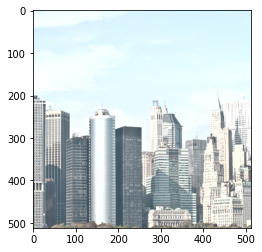

In [5]:
import matplotlib.pyplot as plt
plt.imshow(img)

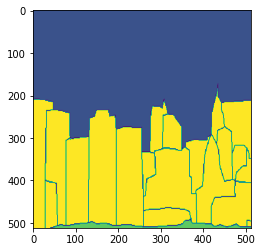

In [6]:
plt.imshow(annot.numpy().argmax(-1))

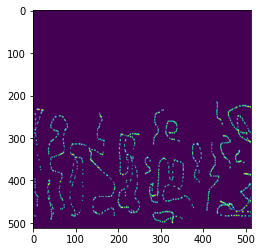

In [7]:
plt.imshow(seed.numpy().argmax(-1))

In [8]:
import wandb
wandb.init(project="skyline12-evidence", tags=['test123'], config={
    'epochs': 50,
    'lambda': 1,
}, notes='try to predict evidence from feature map of 64 depth')
hyperparams = wandb.config

wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [9]:
from models.unet import create_unet
from tensorflow.keras.layers import Input, Conv2D
from metrics import CategoricalMeanIou

unet = create_unet()
unet.load_weights('checkpoints/baseline-weights.h5')

img = Input(shape=(512, 512, 3), name='X')
# x = unet(img)
intermid_unet = tf.keras.Model(unet.input, [unet.output, unet.layers[-2].output])
[x, v] = intermid_unet(img)
v = Conv2D(2, (1, 1), padding='same', kernel_initializer='he_normal', activation='softmax', name='Q')(v)
evid_model = tf.keras.Model(inputs=img, outputs=[x, v])
evid_model.compile(
    optimizer='adam',
    loss=['categorical_crossentropy', 'categorical_crossentropy'],
    loss_weights=[1.0, hyperparams.get('lambda')],
    metrics=[[CategoricalMeanIou(num_classes=5), 'accuracy'], ['accuracy']],
    run_eagerly=False
)

In [10]:
!rm -rf temp
!mkdir -p temp

In [11]:
import wandb
from wandb.keras import WandbCallback
from callbacks import WandbLogEvidencePredictions

early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
class_labels = {
    0: 'Borders',
    1: 'Sky',
    2: 'Unknown',
    3: 'Unknown',
    4: 'Skyscrapers',
}
data_to_log = next(iter(validation_ds.batch(20)))
log_predictions = WandbLogEvidencePredictions(data_to_log, class_labels)

AUTOTUNE = tf.data.experimental.AUTOTUNE
evid_model.fit(
    train_ds.batch(3).cache('temp/').prefetch(AUTOTUNE),
    epochs=hyperparams.get('epochs'),
    validation_data=validation_ds.batch(3).cache('temp/').prefetch(AUTOTUNE),
    callbacks=[
        early_stopper,
        WandbCallback(),
        log_predictions
    ]
)

wandb: Wandb version 0.10.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Epoch 1/50


ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 512, 512, 5) and (None, 512, 512, 64) are incompatible


In [ ]:
foo_x, [foo_y, foo_z] = next(iter(validation_ds.batch(1)))

In [ ]:
y_pred, z_pred = evid_model(foo_x, training=False)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(foo_x[0])

In [ ]:
plt.imshow(y_pred[0].numpy().argmax(-1))

In [ ]:
plt.imshow(z_pred[0].numpy().argmax(-1))

In [ ]:
z_pred[0].numpy()

In [ ]:
unet.summary()